In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt



unzip_path = "S1_Raw_Photographs_Full_Study"  # file path
data_folder = "data"  # Final destination for organized files

# Create subfolders for each class
classes = ["ethanol", "pentane", "propanol"]
for cls in classes:
    os.makedirs(os.path.join(data_folder, cls), exist_ok=True)

# Move files into respective subfolders based on filenames
for root, dirs, files in os.walk(unzip_path):
    for file in files:
        file_path = os.path.join(root, file)
        if "ethanol" in file.lower():
            shutil.move(file_path, os.path.join(data_folder, "ethanol", file))
        elif "pentane" in file.lower():
            shutil.move(file_path, os.path.join(data_folder, "pentane", file))
        elif "propanol" in file.lower():
            shutil.move(file_path, os.path.join(data_folder, "propanol", file))


In [3]:
# Define dataset path
data_folder = "data"

# Load dataset
dataset = ImageFolder(root=data_folder)

# Split into train, val, test sets
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining for testing
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

print(f"Training set: {len(train_set)} images")
print(f"Validation set: {len(val_set)} images")
print(f"Testing set: {len(test_set)} images")

from collections import Counter

# 查看原始數據集中每個類別的樣本數
labels = [sample[1] for sample in dataset.samples]  # 提取所有標籤
label_counts = Counter(labels)

print("Class distribution in the dataset:")
for label, count in label_counts.items():
    print(f"Class {label}: {count} samples")

# 檢查類別數量是否正確
num_classes = len(label_counts)
print(f"Number of classes: {num_classes}")
assert num_classes == 3, "Mismatch between dataset classes and model output."

Training set: 2100 images
Validation set: 450 images
Testing set: 450 images
Class distribution in the dataset:
Class 0: 1000 samples
Class 1: 1000 samples
Class 2: 1000 samples
Number of classes: 3


In [17]:
# Define transformations for the training set
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize images to 224x224
    transforms.RandomRotation(15),         # Randomly rotate images by up to 15 degrees
    transforms.RandomHorizontalFlip(),     # Randomly flip images horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Random color adjustments
    transforms.ToTensor(),                 # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (use ImageNet mean/std)
])

# Define transformations for the validation set
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize images to 224x224
    transforms.ToTensor(),                 # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (use ImageNet mean/std)
])

# Define transformations for the testing set (same as validation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize images to 224x224
    transforms.ToTensor(),                 # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (use ImageNet mean/std)
])

# Apply the transformations to the dataset splits
train_set.dataset.transform = train_transform  # Training with augmentations
val_set.dataset.transform = val_transform      # Validation without augmentations
test_set.dataset.transform = test_transform    # Testing without augmentations
# Define the DataLoader for the test set
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)  # Set batch_size as desired


In [18]:
from torchvision.models import resnet34

# Define the number of classes
num_classes = 3  # 3 burning liquid classes: ethanol, pentane, propanol

# Load the pretrained ResNet-34 model
model = resnet34(pretrained=True)

# Replace the final classification layer (fully connected layer)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Print the model architecture (optional)
print(model)


C:\Users\USER\anaconda3\envs\ee541_work\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\anaconda3\envs\ee541_work\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
import torch
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    """
    Trains and validates the model.
    
        model: PyTorch model to be trained.
        train_loader: DataLoader for the training set.
        val_loader: DataLoader for the validation set.
        criterion: Loss function.
        optimizer: Optimizer for weight updates.
        device: Device to use for training (CPU or GPU).
        num_epochs: Number of epochs for training.

    Returns:
        train_loss_list: List of training losses per epoch.
        train_acc_list: List of training accuracies per epoch.
        val_loss_list: List of validation losses per epoch.
        val_acc_list: List of validation accuracies per epoch.
    """
    # Lists to store metrics for each epoch
    train_loss_list, train_acc_list = [], []
    val_loss_list, val_acc_list = [], []
    # model.train() Training mode
    # model.eval() Validation mode
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 30)

        # Unfreeze deeper layers after `unfreeze_epoch`
        if epoch == unfreeze_epoch:
            print("Unfreezing deeper layers...")
            for param in model.layer4.parameters():  # Unfreeze ResNet's last block
                param.requires_grad = True
                # print(f"Unfreezing layer4: {any(param.requires_grad for param in model.layer4.parameters())}")
        # Training Phase
        model.train()  # Set model to training mode
        running_loss, running_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward() #Calculate back propagation
            optimizer.step()

            # Accumulate loss and correct predictions
            running_loss += loss.item() * inputs.size(0) #loss.item() = scalar, inputs.size(0) = batch size
            _, preds = torch.max(outputs, 1) #outputs = [batch_size, num_classes]
            running_corrects += torch.sum(preds == labels.data)

        # Calculate metrics for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset) #.double() = convert a tensor to the torch.float64 data type
        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc.item())

        print(f"Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        # Validation Phase
        model.eval()  # Set model to evaluation mode
        val_loss, val_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Accumulate loss and correct predictions
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        # Calculate metrics for the epoch
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc.item())

        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list


In [20]:
from torchvision.models import resnet34
import torch.nn as nn
import torch.optim as optim

# Load pretrained ResNet-34 and modify for 3 classes
model = resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 3)  # Adjust for 3 classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True
    
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)  # Experiment with learning rates


In [21]:
batch_sizes = [64] 
learning_rates = [1e-3]
epoch_values = [20]

# Training loop with freezing and unfreezing
unfreeze_epoch = 5  # Unfreeze additional layers after 5 epochs

for batch_size in batch_sizes:
    for lr in learning_rates:
        for num_epochs in epoch_values:
            print(f"Training with batch size={batch_size}, lr={lr}, epochs={num_epochs}")
            
            # Update DataLoader
            train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
            
            # Update Optimizer (only trainable parameters)
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
            
            # Train Model
            train_loss, train_acc, val_loss, val_acc = train_model(
                model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs
            )


Training with batch size=64, lr=0.001, epochs=20
Epoch 1/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.96it/s]


Training Loss: 0.7989, Accuracy: 0.6581


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.28it/s]


Validation Loss: 0.4774, Accuracy: 0.8689
Epoch 2/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.02it/s]


Training Loss: 0.3797, Accuracy: 0.8900


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.29it/s]


Validation Loss: 0.2940, Accuracy: 0.9244
Epoch 3/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.99it/s]


Training Loss: 0.2838, Accuracy: 0.9162


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.26it/s]


Validation Loss: 0.2410, Accuracy: 0.9378
Epoch 4/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.97it/s]


Training Loss: 0.2495, Accuracy: 0.9243


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.24it/s]


Validation Loss: 0.2167, Accuracy: 0.9467
Epoch 5/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.94it/s]


Training Loss: 0.2117, Accuracy: 0.9305


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.17it/s]


Validation Loss: 0.2001, Accuracy: 0.9467
Epoch 6/20
------------------------------
Unfreezing deeper layers...
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True
Unfreezing layer4: True


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.89it/s]


Training Loss: 0.1853, Accuracy: 0.9443


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.24it/s]


Validation Loss: 0.1765, Accuracy: 0.9578
Epoch 7/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.95it/s]


Training Loss: 0.1849, Accuracy: 0.9405


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.25it/s]


Validation Loss: 0.1690, Accuracy: 0.9556
Epoch 8/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.84it/s]


Training Loss: 0.1551, Accuracy: 0.9576


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.27it/s]


Validation Loss: 0.1529, Accuracy: 0.9622
Epoch 9/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.95it/s]


Training Loss: 0.1499, Accuracy: 0.9557


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.12it/s]


Validation Loss: 0.1517, Accuracy: 0.9622
Epoch 10/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.94it/s]


Training Loss: 0.1441, Accuracy: 0.9581


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.23it/s]


Validation Loss: 0.1421, Accuracy: 0.9644
Epoch 11/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.94it/s]


Training Loss: 0.1322, Accuracy: 0.9610


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.25it/s]


Validation Loss: 0.1354, Accuracy: 0.9644
Epoch 12/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.94it/s]


Training Loss: 0.1273, Accuracy: 0.9619


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.21it/s]


Validation Loss: 0.1338, Accuracy: 0.9644
Epoch 13/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.89it/s]


Training Loss: 0.1279, Accuracy: 0.9610


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.18it/s]


Validation Loss: 0.1341, Accuracy: 0.9600
Epoch 14/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.91it/s]


Training Loss: 0.1139, Accuracy: 0.9695


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.17it/s]


Validation Loss: 0.1282, Accuracy: 0.9644
Epoch 15/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.90it/s]


Training Loss: 0.1198, Accuracy: 0.9629


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.18it/s]


Validation Loss: 0.1259, Accuracy: 0.9622
Epoch 16/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.94it/s]


Training Loss: 0.1084, Accuracy: 0.9671


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  2.00it/s]


Validation Loss: 0.1233, Accuracy: 0.9622
Epoch 17/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.72it/s]


Training Loss: 0.0996, Accuracy: 0.9738


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.04it/s]


Validation Loss: 0.1194, Accuracy: 0.9622
Epoch 18/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.81it/s]


Training Loss: 0.0941, Accuracy: 0.9719


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.88it/s]


Validation Loss: 0.1119, Accuracy: 0.9644
Epoch 19/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.93it/s]


Training Loss: 0.0926, Accuracy: 0.9748


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.24it/s]


Validation Loss: 0.1109, Accuracy: 0.9711
Epoch 20/20
------------------------------


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.94it/s]


Training Loss: 0.1000, Accuracy: 0.9657


Validation: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.20it/s]

Validation Loss: 0.1130, Accuracy: 0.9689


In [29]:
from torchvision.models import resnet34
import torch.nn as nn
import torch
from tqdm import tqdm

# Load ResNet-34 with pretrained weights
model_pretrained = resnet34(pretrained=True)
model.to(device)
# Replace the fully connected layer to match the number of classes in your dataset
num_classes = 3  # Replace with the actual number of classes
model_pretrained.fc = nn.Linear(model_pretrained.fc.in_features, num_classes)

# Set the model to evaluation mode
model_pretrained.eval()


def evaluate_model(model, test_loader, device):
    """
    Evaluates the model on the test set and computes accuracy.

    Args:
        model: PyTorch model to be evaluated.
        test_loader: DataLoader for the test set.
        device: Device to perform evaluation (CPU or GPU).

    Returns:
        test_acc: Accuracy of the model on the test set.
    """
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    test_corrects = 0
    test_total = 0

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get predicted classes
            
            # Count correct predictions
            test_corrects += torch.sum(preds == labels.data)
            test_total += labels.size(0)
    
    # Calculate accuracy
    test_acc = test_corrects.double() / test_total
    return test_acc.item()

# Assuming `test_loader` is your DataLoader for the test set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pretrained = model_pretrained.to(device)
baseline_accuracy = evaluate_model(model_pretrained, test_loader, device)
print(f"Baseline Accuracy (Pretrained ResNet-34): {baseline_accuracy:.4f}")

# Fine-tuned model (assume it's already trained)
fine_tuned_accuracy = evaluate_model(model, test_loader, device)
print(f"Fine-Tuned Model Accuracy: {fine_tuned_accuracy:.4f}")

C:\Users\USER\anaconda3\envs\ee541_work\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\anaconda3\envs\ee541_work\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.41it/s]


Baseline Accuracy (Pretrained ResNet-34): 0.3044


Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.52it/s]

Fine-Tuned Model Accuracy: 0.9489


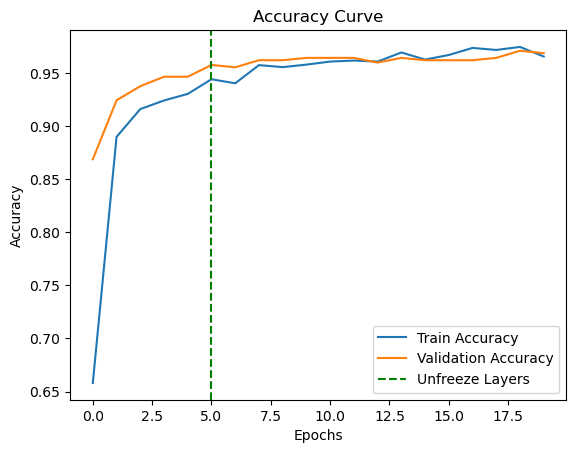

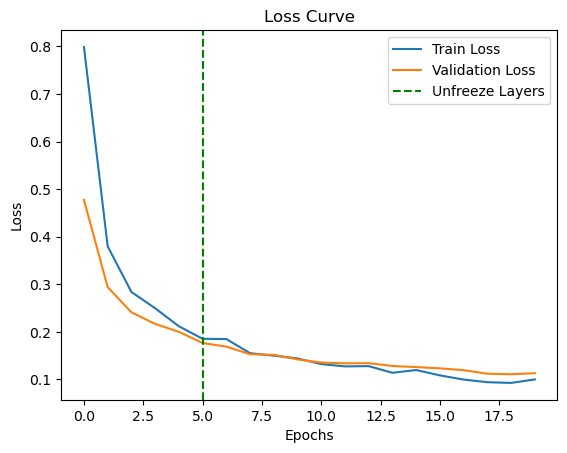

In [23]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
plt.figure()
plt.plot(range(len(train_acc)), train_acc, label="Train Accuracy")
plt.plot(range(len(val_acc)), val_acc, label="Validation Accuracy")
plt.axvline(x=unfreeze_epoch, color="green", linestyle="--", label="Unfreeze Layers")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.figure()
plt.plot(range(len(train_loss)), train_loss, label="Train Loss")
plt.plot(range(len(val_loss)), val_loss, label="Validation Loss")
plt.axvline(x=unfreeze_epoch, color="green", linestyle="--", label="Unfreeze Layers")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


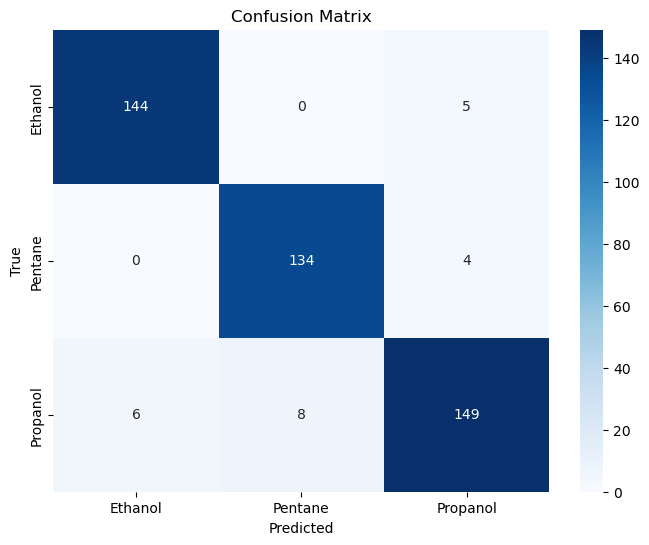

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
classes = ["Ethanol", "Pentane", "Propanol"]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


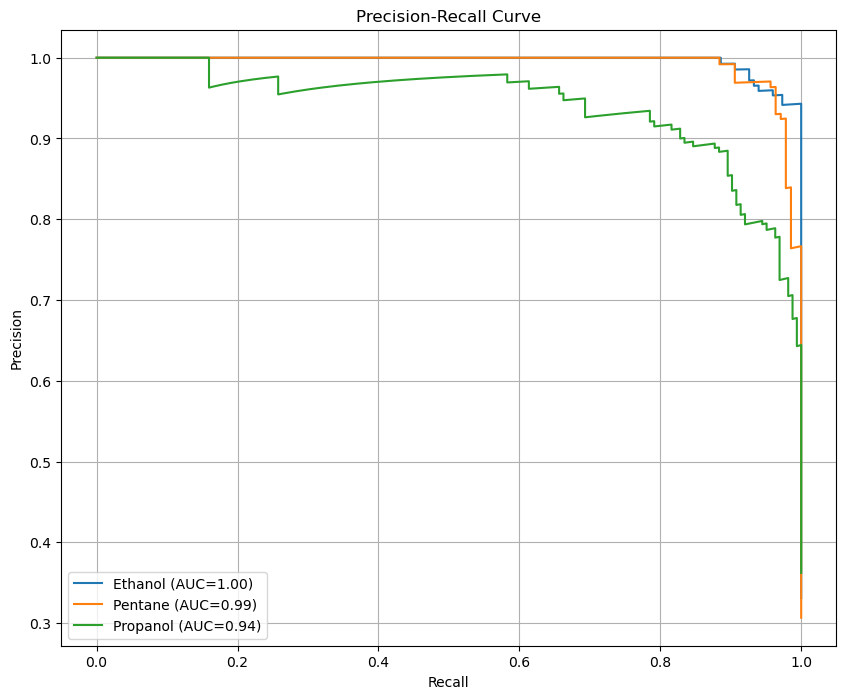

In [28]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for multi-class (one-vs-rest)
y_true = label_binarize(all_labels, classes=[0, 1, 2])  # Replace with actual class indices
y_score = []

# Get class probabilities
model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_score.extend(outputs.cpu().numpy())  # Class probabilities

y_score = np.array(y_score)

# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_score[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{class_name} (AUC={pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


Input size: torch.Size([1, 3, 224, 224])
Visualizing 64 filters...


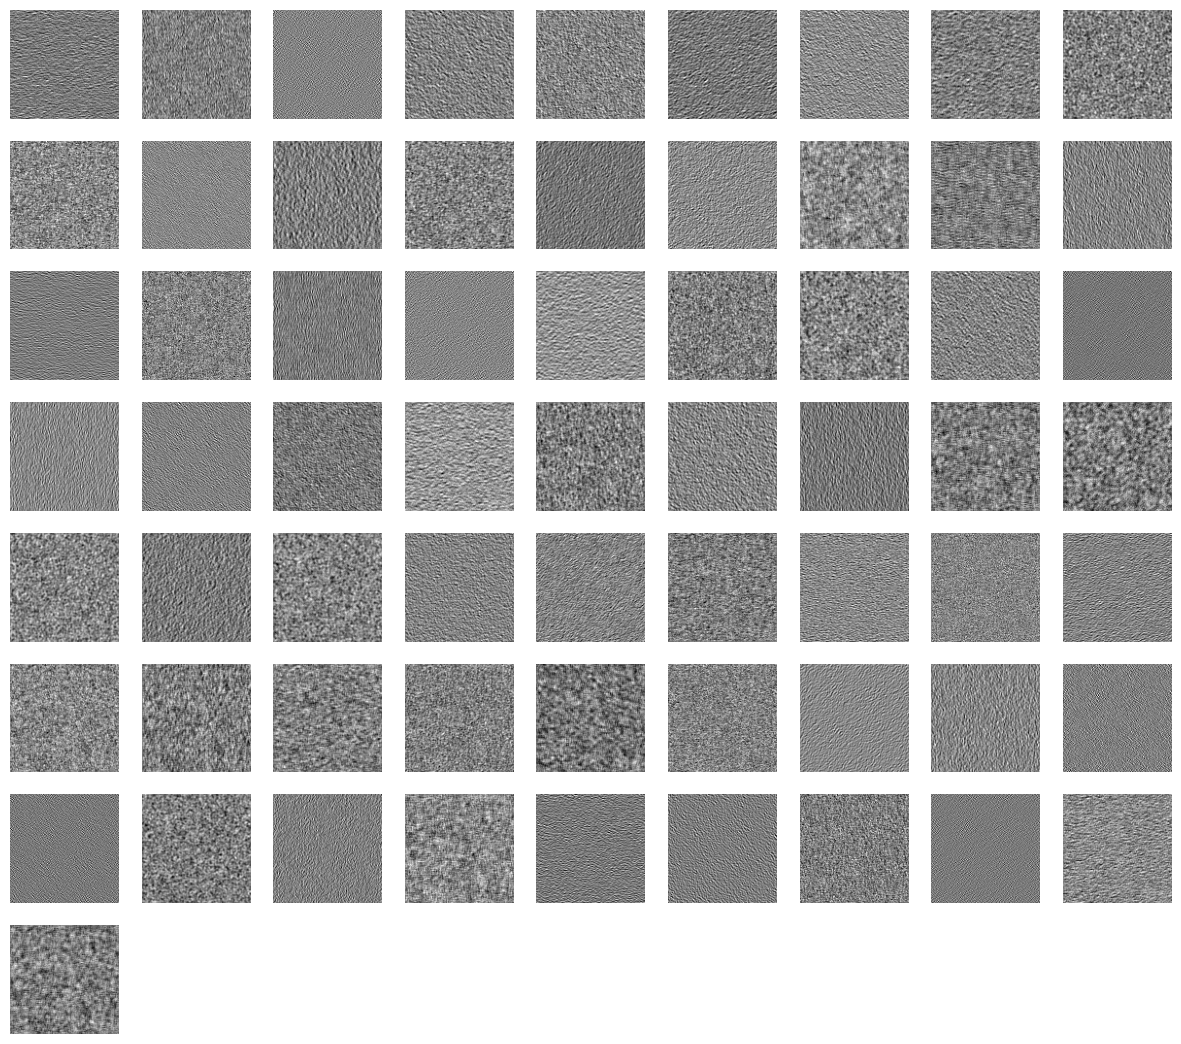

In [30]:
import torch
import matplotlib.pyplot as plt
from torchvision.models import resnet34

# Load the pretrained model
model = resnet34(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define a hook function to visualize feature maps
def visualize_hook(module, input, output):
    num_filters = min(output.size(1), 64)  # Limit to 64 filters
    grid_size = int(num_filters**0.5) + 1  # Dynamically calculate grid size
    print(f"Visualizing {num_filters} filters...")
    plt.figure(figsize=(15, 15))
    for i in range(num_filters):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(output[0, i].detach().cpu().numpy(), cmap="gray")
        plt.axis("off")
    plt.show()

# Choose a layer to visualize
layer_to_visualize = model.conv1  # First convolutional layer
hook = layer_to_visualize.register_forward_hook(visualize_hook)

# Prepare an input image and move it to the same device as the model
image = torch.randn(1, 3, 224, 224).to(device)  # Move to the same device as the model

print(f"Input size: {image.size()}")

# Run the image through the model
_ = model(image)

# Remove the hook
hook.remove()


Visualizing 64 filters...


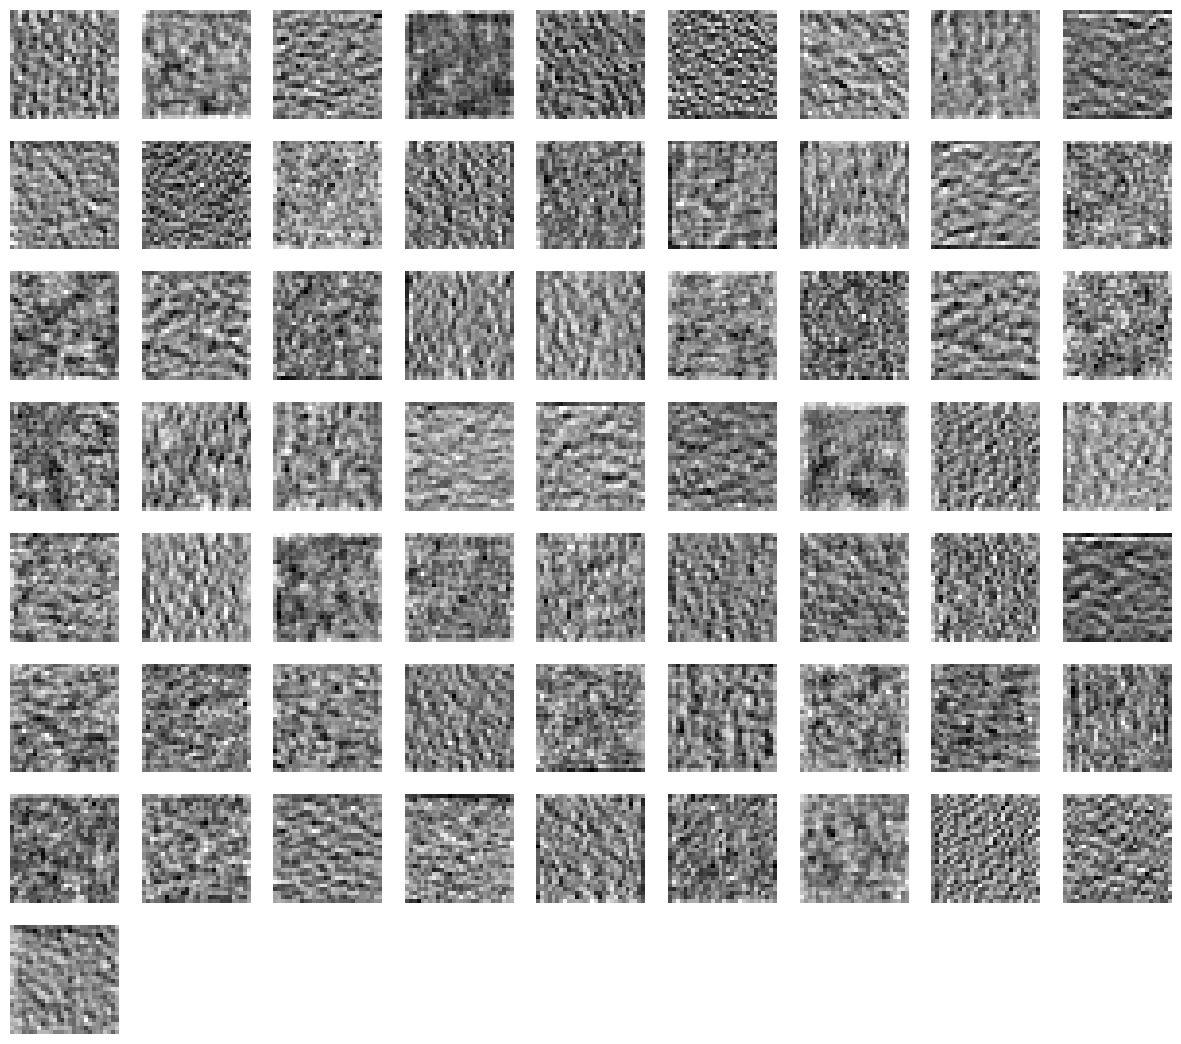

In [31]:
# Choose a deeper layer to visualize
layer_to_visualize = model.layer2[1].conv1  # Second block of layer3, first convolution

# Register the hook
hook = layer_to_visualize.register_forward_hook(visualize_hook)

# Pass an image through the model
_ = model(image)

# Remove the hook
hook.remove()


Visualizing 64 filters...


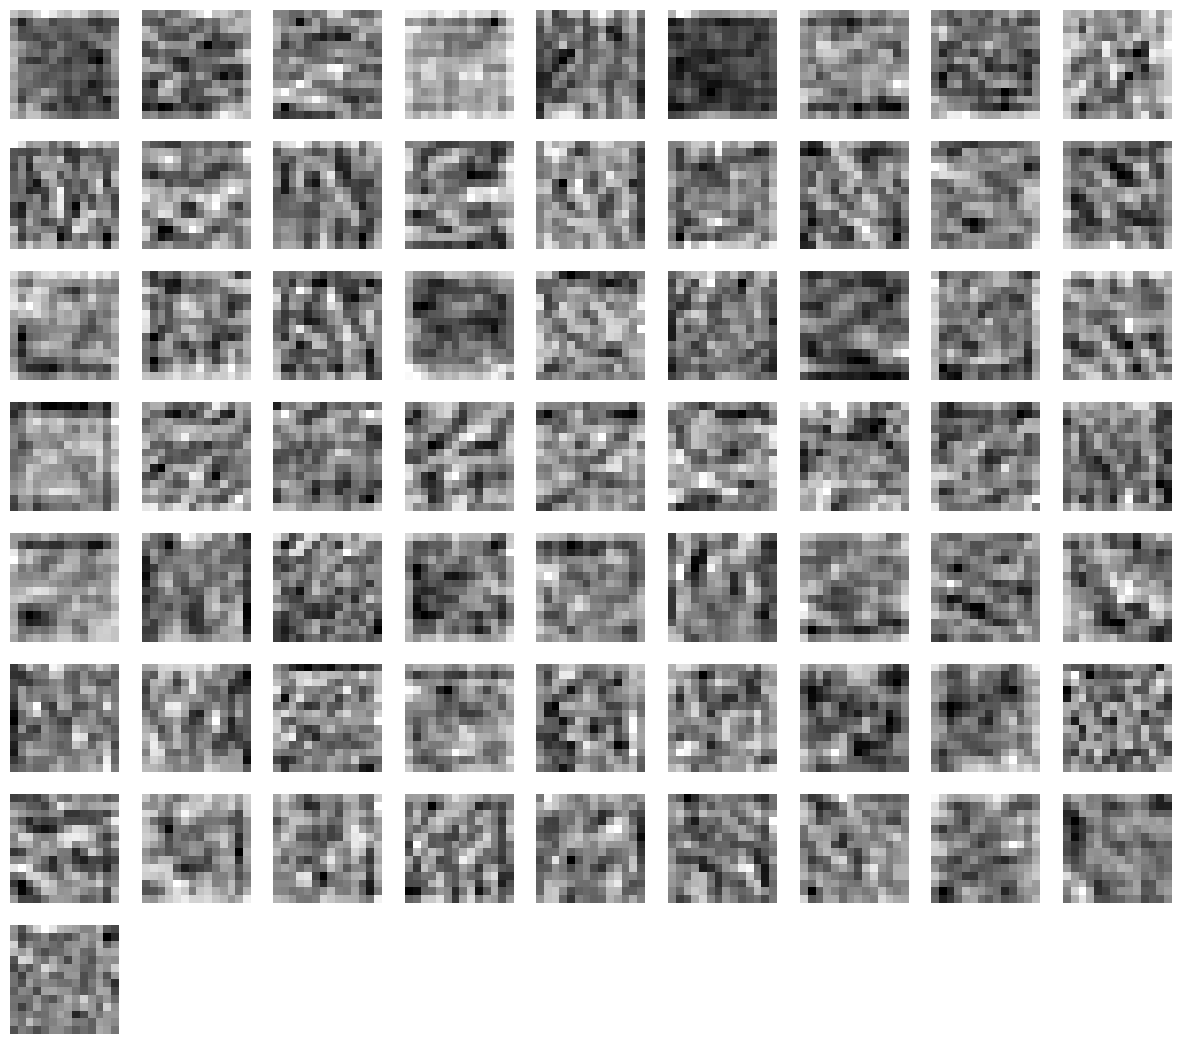

In [32]:
# Choose a deeper layer to visualize
layer_to_visualize = model.layer3[1].conv1  # Second block of layer3, first convolution

# Register the hook
hook = layer_to_visualize.register_forward_hook(visualize_hook)

# Pass an image through the model
_ = model(image)

# Remove the hook
hook.remove()
